#### 1 Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
#### 2 Добавьте первые разности по стоимости доллара и евро к рублю
#### 3 сделайте ее перрасчет (ресемплинг) в представление по неделям.
#### 4 Постройте модель предсказания 1-й точки от текущей (h=1).
#### 5 Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.3)
import warnings 

from itertools import product
from sklearn.preprocessing import StandardScaler


%matplotlib inline

Цены на золото http://www.cbr.ru/hd_base/metall/metall_base_new/?UniDbQuery.Posted=True&UniDbQuery.Gold=true&UniDbQuery.FromDate=02.09.2010&UniDbQuery.ToDate=30.08.2019

In [2]:
data = pd.read_csv('data/my_BRENT2019.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
gold = pd.read_excel('data/gold cb.xlsx', index_col=[0], parse_dates=[0])
ruble_dollar = pd.read_excel('data/RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])
ruble_dollar.drop(columns=['nominal', 'cdx'], inplace=True)
ruble_dollar.rename(columns={'curs': 'dollar'}, inplace=True)
ruble_euro = pd.read_excel('data/R_E01_09_2010_T01_09_2019.xlsx', index_col=[1], parse_dates=[1])
ruble_euro.drop(columns=['nominal', 'cdx'], inplace=True)
ruble_euro.rename(columns={'curs': 'euro'}, inplace=True)
data = pd.concat([data['Значение'], ruble_dollar, ruble_euro, gold], axis=1)

In [3]:
data['Значение'].fillna(method='ffill', inplace=True)
data['dollar'].fillna(method='ffill', inplace=True)
data['euro'].fillna(method='ffill', inplace=True)
data['gold'].fillna(method='ffill', inplace=True)
data = data.rename(columns = {'Значение':'brent'})
data.head(100)

,brent,dollar,euro,gold
2010-09-01,76.37,30.8669,39.0127,1224.12
2010-09-02,76.89,30.8001,39.1654,1237.81
2010-09-03,76.57,30.6858,39.2901,1230.99
2010-09-04,76.62,30.6922,39.3505,1235.44
2010-09-05,76.63,30.6922,39.3505,1235.44
...,...,...,...,...
2010-12-07,90.90,31.2867,41.7677,1419.81
2010-12-08,91.18,31.2238,41.6525,1431.52
2010-12-09,90.97,31.2430,41.2720,1401.26
2010-12-10,90.73,30.9831,41.2106,1376.65


In [4]:
data['brent_diff'] = data['brent'] - data['brent'].shift(1)
data['dollar_diff'] = data['dollar'] - data['dollar'].shift(1)
data['euro_diff'] = data['euro'] - data['euro'].shift(1)
data['gold_diff'] = data['gold'] - data['gold'].shift(1)

In [5]:
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
data_w = data.resample("W").mean()
data_w.head()

,brent,dollar,euro,gold,brent_diff,dollar_diff,euro_diff,gold_diff
2010-09-05,76.616000,30.747440,39.233840,1232.760000,0.065000,-0.043675,0.084450,2.830000
2010-09-12,77.673333,30.777050,39.302883,1238.371667,0.288333,0.033583,-0.026467,0.815000
2010-09-19,78.590000,30.887129,39.984557,1255.501429,-0.018571,0.026986,0.231400,5.758571
2010-09-26,78.558571,31.003800,41.040657,1284.394286,0.101429,-0.019229,0.064057,1.552857
2010-10-03,81.582857,30.585086,41.382686,1282.487143,0.678571,-0.062657,0.057243,-0.512857


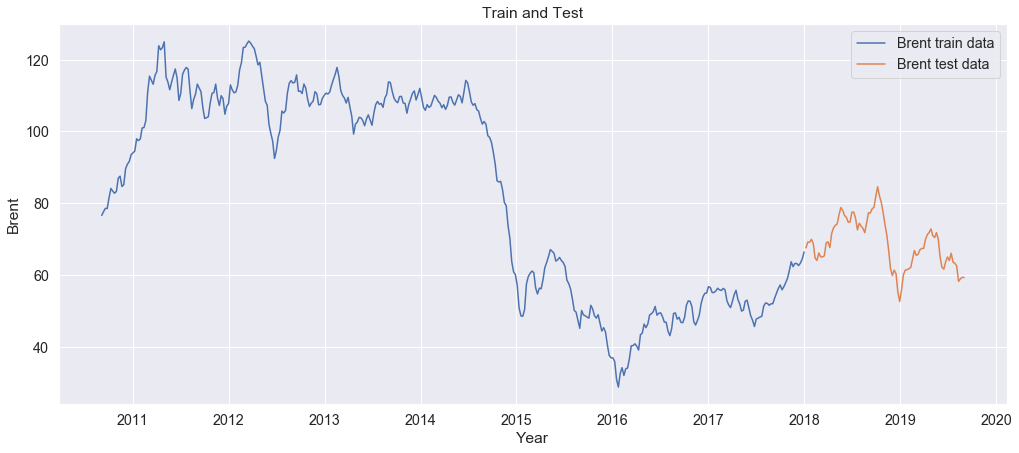

In [7]:
date_for_split = '01-01-2018'

train, test = split_data( data_w, date_for_split)

plt.figure( figsize=( 17, 7 ))
plt.xlabel('Year')
plt.ylabel('Brent')
plt.plot(train.index,train.iloc[:,0], label='Brent train data' )
plt.plot(test.index,test.iloc[:,0], label='Brent test data')

plt.title( 'Train and Test' )
plt.legend()
plt.show()

In [8]:
h = 1

X_train = train.iloc[:-h,:]
y_train = train['brent_diff'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['brent_diff'].values[h:]

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

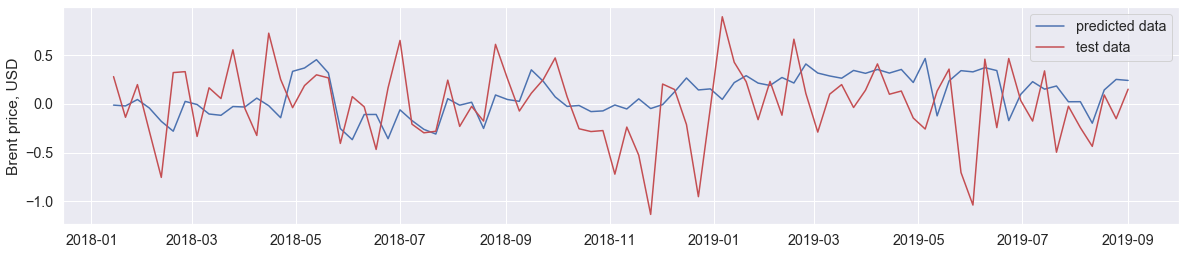

ошибка градиентного бустинга :   148.07874459749902 %


In [10]:
h = 1

gr_model = GradientBoostingRegressor(max_depth=8, random_state=0, n_estimators=45)
gr_model.fit( X_train, y_train ) 
X_test_pred = gr_model.predict(X_test)
plt.figure( figsize=( 20, 4 ))

plt.ylabel('Brent price, USD')
plt.plot(test.index[h:],X_test_pred, label='predicted data', color='b' )
plt.plot(test.index[h:],y_test, label='test data', color='r')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка градиентного бустинга :  ', er_g, '%')

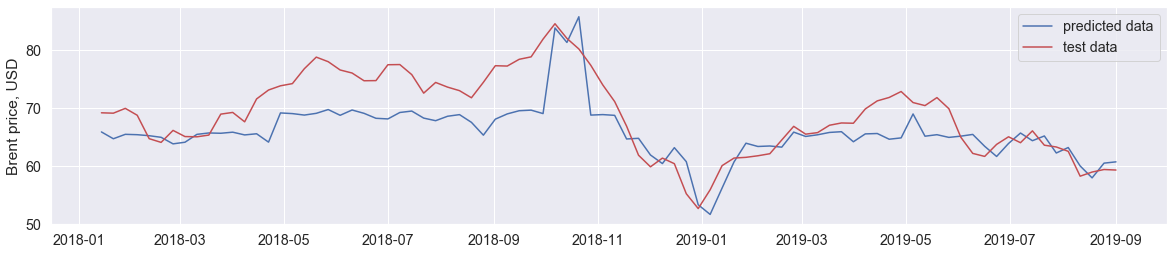

ошибка градиентного бустинга :   5.517197146790806 %


In [11]:
train, test = split_data( data_w, date_for_split)

h = 1
X_train = train.iloc[:-h,:]
y_train = train['brent'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['brent'].values[h:]

gb_model = GradientBoostingRegressor(max_depth=8, random_state=0, n_estimators=45)
gb_model.fit( X_train, y_train ) 
X_test_pred = gb_model.predict(X_test)
plt.figure( figsize=( 20, 4 ))

plt.ylabel('Brent price, USD')
plt.plot(test.index[h:],X_test_pred, label='predicted data', color='b' )
plt.plot(test.index[h:],y_test, label='test data', color='r')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка градиентного бустинга :  ', er_g, '%')

Вывод: Ошибка по первым разностям не выдерживает критики. Ошибки прямого прогнозирования в пределах нормы. Предсказывать первые разности осложнено более мелкими значениями за счет чего увеличивается ошибка и более хаотичное распределение.